The type of mnist_ds: <class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>
Number of pictures contained in the mnist_ds： 60000
The item of mnist_ds: dict_keys(['image', 'label'])
Tensor of image in item: (28, 28, 1)
The label of item: 9


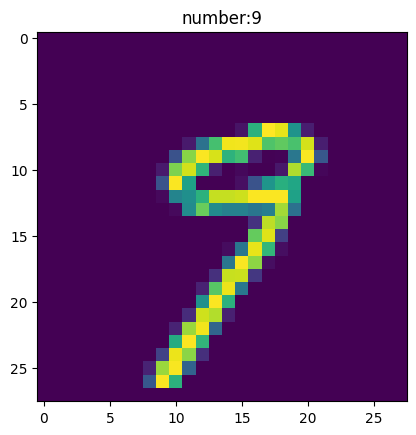

In [1]:
from mindspore import context
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import mindspore.dataset as ds

context.set_context(mode=context.GRAPH_MODE,
                    device_target="GPU")  # Windows version, set to use CPU for graph calculation
train_data_path = "./data/train"
test_data_path = "./data/test"
mnist_ds = ds.MnistDataset(train_data_path)  # Load training dataset
print('The type of mnist_ds:', type(mnist_ds))
print("Number of pictures contained in the mnist_ds：", mnist_ds.get_dataset_size())  # 60000 pictures in total

dic_ds = mnist_ds.create_dict_iterator()  # Convert dataset to dictionary type
item = dic_ds.__next__()
img = item["image"].asnumpy()
label = item["label"].asnumpy()

print("The item of mnist_ds:",
      item.keys())  # Take a single data to view the data structure, including two keys, image and label
print("Tensor of image in item:", img.shape)  # View the tensor of image (28,28,1)
print("The label of item:", label)

plt.imshow(np.squeeze(img))
plt.title("number:%s" % item["label"])
plt.show()

In [2]:
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore.common import dtype as mstype


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """ create dataset for train or test
    Args:
        data_path: Data path
        batch_size: The number of data records in each group
        repeat_size: The number of replicated data records
        num_parallel_workers: The number of parallel workers
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # Define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # According to the parameters, generate the corresponding data enhancement method
    resize_op = CV.Resize((resize_height, resize_width),
                          interpolation=Inter.LINEAR)  # Resize images to (32, 32) by bilinear interpolation
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)  # normalize images
    rescale_op = CV.Rescale(rescale, shift)  # rescale images
    hwc2chw_op = CV.HWC2CHW()  # change shape from (height, width, channel) to (channel, height, width) to fit network.
    type_cast_op = C.TypeCast(mstype.int32)  # change data type of label to int32 to fit network

    # Using map () to apply operations to a dataset
    mnist_ds = mnist_ds.map(input_columns="label", operations=type_cast_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=resize_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_nml_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=hwc2chw_op, num_parallel_workers=num_parallel_workers)
    # Process the generated dataset
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)  # 10000 as in LeNet train script
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

In [3]:
datas = create_dataset(train_data_path)  # Process the train dataset
print('Number of groups in the dataset:', datas.get_dataset_size())  # Number of query dataset groups

Number of groups in the dataset: 1875


In [4]:
data = datas.create_dict_iterator().__next__()  # Take a set of datasets
print(data.keys())
images = data["image"].asnumpy()  # Take out the image data in this dataset
labels = data["label"].asnumpy()  # Take out the label (subscript) of this data set
print('Tensor of image:', images.shape)  # Query the tensor of images in each dataset (32,1,32,32)
print('labels:', labels)

dict_keys(['image', 'label'])
Tensor of image: (32, 1, 32, 32)
labels: [3 0 9 2 5 1 3 2 5 7 9 6 7 5 9 1 9 1 5 2 2 7 0 5 3 4 7 3 0 4 4 3]


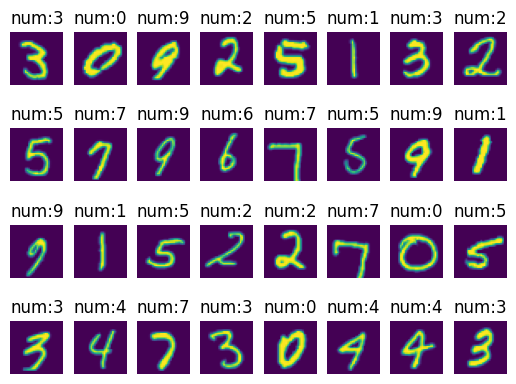

In [5]:
count = 1
for i in images:
    plt.subplot(4, 8, count)
    plt.imshow(np.squeeze(i))
    plt.title('num:%s' % labels[count - 1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()  # Print a total of 32 pictures in the group

In [6]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal


# Initialize 2D convolution function
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """Conv layer weight initial."""
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")


# Initialize full connection layer
def fc_with_initialize(input_channels, out_channels):
    """Fc layer weight initial."""
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)


# Set truncated normal distribution
def weight_variable():
    """Weight initial."""
    return TruncatedNormal(0.02)

In [7]:
class LeNet5(nn.Cell):
    """Lenet network structure."""

    # define the operator required
    def __init__(self):
        super(LeNet5, self).__init__()
        self.batch_size = 32  # 32 pictures in each group
        self.conv1 = conv(1, 6,
                          5)  # Convolution layer 1, 1 channel input (1 Figure), 6 channel output (6 figures), convolution core 5 * 5
        self.conv2 = conv(6, 16, 5)  # Convolution layer 2,6-channel input, 16 channel output, convolution kernel 5 * 5
        self.fc1 = fc_with_initialize(16 * 5 * 5, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.conv1(x)  # 1*32*32-->6*28*28
        x = self.relu(x)  # 6*28*28-->6*14*14
        x = self.max_pool2d(x)  # Pool layer
        x = self.conv2(x)  # Convolution layer
        x = self.relu(x)  # Function excitation layer
        x = self.max_pool2d(x)  # Pool layer
        x = self.flatten(x)  # Dimensionality reduction
        x = self.fc1(x)  # Full connection
        x = self.relu(x)  # Function excitation layer
        x = self.fc2(x)  # Full connection
        x = self.relu(x)  # Function excitation layer
        x = self.fc3(x)  # Full connection
        return x

In [8]:
network = LeNet5()
print(network)

LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x7f887af89990>, bias_init=zeros, format=NCHW>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x7f88bc2c7e90>, bias_init=zeros, format=NCHW>
  (fc1): Dense<input_channels=400, output_channels=120, has_bias=True>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (fc3): Dense<input_channels=84, output_channels=10, has_bias=True>
  (relu): ReLU<>
  (max_pool2d): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  >


In [9]:
param = network.trainable_params()
param

[Parameter (name=conv1.weight, shape=(6, 1, 5, 5), dtype=Float32, requires_grad=True),
 Parameter (name=conv2.weight, shape=(16, 6, 5, 5), dtype=Float32, requires_grad=True),
 Parameter (name=fc1.weight, shape=(120, 400), dtype=Float32, requires_grad=True),
 Parameter (name=fc1.bias, shape=(120,), dtype=Float32, requires_grad=True),
 Parameter (name=fc2.weight, shape=(84, 120), dtype=Float32, requires_grad=True),
 Parameter (name=fc2.bias, shape=(84,), dtype=Float32, requires_grad=True),
 Parameter (name=fc3.weight, shape=(10, 84), dtype=Float32, requires_grad=True),
 Parameter (name=fc3.bias, shape=(10,), dtype=Float32, requires_grad=True)]

In [10]:
# Training and testing related modules
import argparse
import os
from mindspore import Tensor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, Callback
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits


def train_net(model, epoch_size, mnist_path, repeat_size, ckpoint_cb, step_loss_info):
    """Define the training method."""
    print("============== Starting Training ==============")
    # load training dataset
    ds_train = create_dataset(os.path.join(mnist_path, "train"), 32, repeat_size)
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(), step_loss_info], dataset_sink_mode=True)

In [11]:
# Custom callback function
class Step_loss_info(Callback):
    def step_end(self, run_context):
        cb_params = run_context.original_args()
        # step_ Loss dictionary for saving loss value and step number information
        step_loss["loss_value"].append(str(cb_params.net_outputs))
        step_loss["step"].append(str(cb_params.cur_step_num))

In [12]:
import os

if os.name == "nt":
    os.system('del/f/s/q *.ckpt *.meta')  # Clean up old run files before in Windows
else:
    os.system('rm -f *.ckpt *.meta *.pb')  # Clean up old run files before in Linux

lr = 0.01  # learning rate
momentum = 0.9  #

# create the network
network = LeNet5()

# define the optimizer
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)

# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# define the model
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
epoch_size = 10
mnist_path = "./data"

config_ck = CheckpointConfig(save_checkpoint_steps=125, keep_checkpoint_max=16)
# save the network model and parameters for subsequence fine-tuning

ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck, directory="./checkpoints")
# group layers into an object with training and evaluation features
step_loss = {"step": [], "loss_value": []}
# step_ Loss dictionary for saving loss value and step number information
step_loss_info = Step_loss_info()
# save the steps and loss value
repeat_size = 1
train_net(model, epoch_size, mnist_path, repeat_size, ckpoint_cb, step_loss_info)

============== Starting Training ==============
epoch: 1 step: 1875, loss is 0.06146371364593506
epoch: 2 step: 1875, loss is 0.07509348541498184
epoch: 3 step: 1875, loss is 0.005253412760794163
epoch: 4 step: 1875, loss is 0.09573438763618469
epoch: 5 step: 1875, loss is 0.019676880910992622
epoch: 6 step: 1875, loss is 0.002663913182914257
epoch: 7 step: 1875, loss is 0.006454060785472393
epoch: 8 step: 1875, loss is 0.02024470828473568
epoch: 9 step: 1875, loss is 5.492568016052246e-05
epoch: 10 step: 1875, loss is 0.033898647874593735


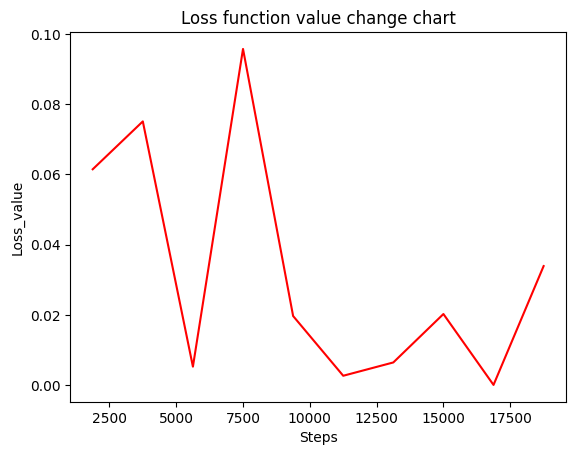

In [13]:
steps = step_loss["step"]
loss_value = step_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Loss function value change chart")
plt.show()

In [14]:
def test_net(network, model, mnist_path):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = load_checkpoint("./checkpoints/checkpoint_lenet-10_1875.ckpt")
    # load parameter to the network
    load_param_into_net(network, param_dict)
    # load testing dataset
    ds_eval = create_dataset(os.path.join(mnist_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=True)
    print("============== Accuracy:{} ==============".format(acc))


test_net(network, model, mnist_path)

============== Starting Testing ==============
============== Accuracy:{'Accuracy': 0.9895833333333334} ==============


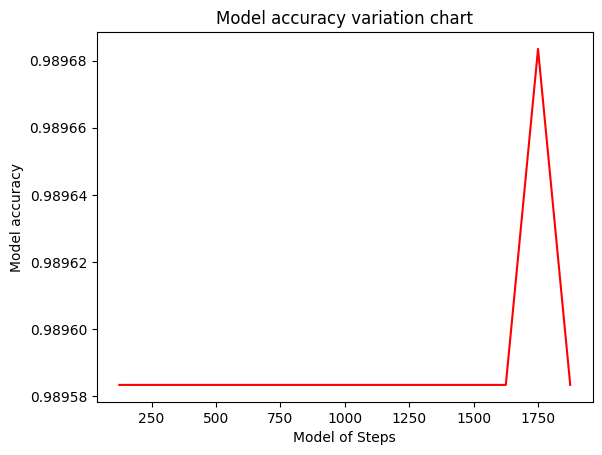

In [15]:
def acc_model_info(network, model, mnist_path, model_numbers, epoch_size):
    """Define the plot info method"""
    step_list = []
    acc_list = []
    for i in range(1, epoch_size + 1):
        # load the saved model for evaluation
        #加载同一个模型得到的模型训练步数变化，精度随之变化
        param_dict = load_checkpoint("./checkpoints/checkpoint_lenet-10_1875.ckpt")
        #加载不同一个模型得到的模型训练步数变化，精度随之变化
        #param_dict = load_checkpoint("checkpoint_lenet-{}_1875.ckpt".format(str(i)))

        # load parameter to the network
        load_param_into_net(network, param_dict)
        # load testing dataset
    for i in range(1, model_numbers + 1):
        ds_eval = create_dataset(os.path.join(mnist_path, "test"))
        acc = model.eval(ds_eval, dataset_sink_mode=True)
        acc_list.append(acc['Accuracy'])
        step_list.append(i * 125)
    return step_list, acc_list


# Draw line chart according to training steps and model accuracy
l1, l2 = acc_model_info(network, model, mnist_path, 15, 10)
plt.xlabel("Model of Steps")
plt.ylabel("Model accuracy")
plt.title("Model accuracy variation chart")
plt.plot(l1, l2, 'red')
plt.show()

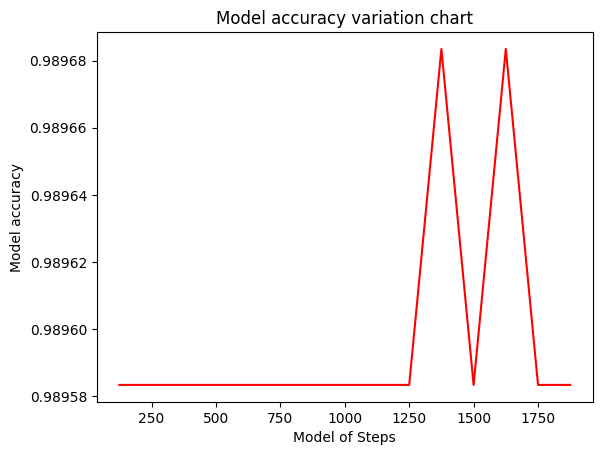

In [16]:
def acc_model_info(network, model, mnist_path, model_numbers, epoch_size):
    """Define the plot info method"""
    step_list = []
    acc_list = []
    for i in range(1, epoch_size + 1):
        # load the saved model for evaluation
        #加载同一个模型得到的模型训练步数变化，精度随之变化
        # param_dict = load_checkpoint("./checkpoints/checkpoint_lenet-10_1875.ckpt")
        #加载不同一个模型得到的模型训练步数变化，精度随之变化
        param_dict = load_checkpoint("./checkpoints/checkpoint_lenet-{}_1875.ckpt".format(str(i)))

        # load parameter to the network
        load_param_into_net(network, param_dict)
        # load testing dataset
    for i in range(1, model_numbers + 1):
        ds_eval = create_dataset(os.path.join(mnist_path, "test"))
        acc = model.eval(ds_eval, dataset_sink_mode=True)
        acc_list.append(acc['Accuracy'])
        step_list.append(i * 125)
    return step_list, acc_list


# Draw line chart according to training steps and model accuracy
l1, l2 = acc_model_info(network, model, mnist_path, 15, 10)
plt.xlabel("Model of Steps")
plt.ylabel("Model accuracy")
plt.title("Model accuracy variation chart")
plt.plot(l1, l2, 'red')
plt.show()

All the figures in this group are predicted correctly！
[0 0 2 3 9 7 0 3 5 1 5 3 2 2 4 8 5 9 4 4 8 7 9 0 0 8 1 8 2 4 7 2] <--Predicted figures
[0 0 2 3 9 7 0 3 5 1 5 3 2 2 4 8 5 9 4 4 8 7 9 0 0 8 1 8 2 4 7 2] <--The right number


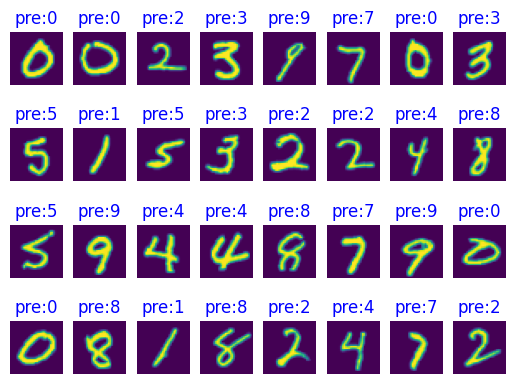

In [17]:
ds_test = create_dataset(test_data_path).create_dict_iterator()
data = ds_test.__next__()
images = data["image"].asnumpy()
labels = data[
    "label"].asnumpy()  # The subscript of data picture is the standard for us to judge whether it is correct or not

output = model.predict(Tensor(data['image']))
# The predict function returns the probability of 0-9 numbers corresponding to each picture
prb = output.asnumpy()
pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i + 1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        # Print out the wrong data identified by the current group
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i / 8) + 1,
                                                                                                         i % 8 + 1,
                                                                                                         pred[i],
                                                                                                         labels[i]),
              '\n')
if index:
    print("All the figures in this group are predicted correctly！")
print(pred, "<--Predicted figures")  # Print the numbers recognized by each group of pictures
print(labels, "<--The right number")  # Print the subscript corresponding to each group of pictures
plt.show()

Figure 1 probability of corresponding numbers [0-9]:
 [22.318357   -5.885889   -4.998237   -2.2800646  -3.1224556   0.02736468
  1.4130981  -2.4081218  -4.67135     0.40052468]


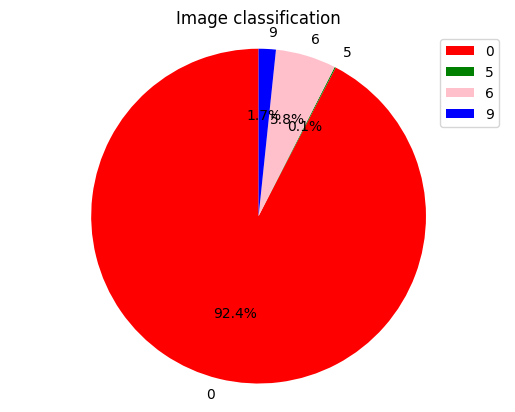

Figure 2 probability of corresponding numbers [0-9]:
 [14.478987   -5.8206587  -3.401665   -3.0667114   1.0151279  -1.7664444
 -1.1349185  -0.54939455 -3.732542    4.680178  ]


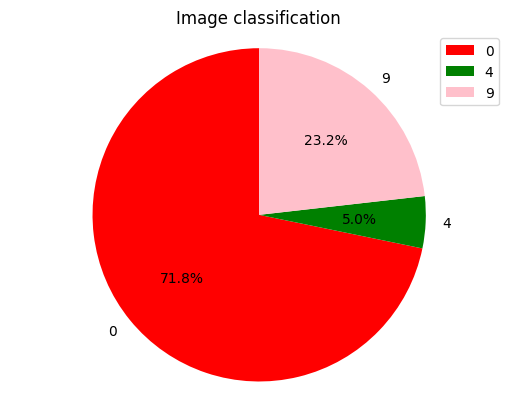

In [18]:
# define the pie drawing function of probability analysis
def plot_pie(prbs):
    dict1 = {}
    # Remove the negative number and build the dictionary dict1. The key is the number and the value is the probability value
    for i in range(10):
        if prbs[i] > 0:
            dict1[str(i)] = prbs[i]

    label_list = dict1.keys()  # Label of each part
    size = dict1.values()  # Size of each part
    colors = ["red", "green", "pink", "blue", "purple", "orange", "gray"]  # Building a round cake pigment Library
    color = colors[: len(size)]  # Color of each part
    plt.pie(size, colors=color, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90,
            pctdistance=0.6)
    plt.axis("equal")  # Set the scale size of x-axis and y-axis to be equal
    plt.legend()
    plt.title("Image classification")
    plt.show()


for i in range(2):
    print("Figure {} probability of corresponding numbers [0-9]:\n".format(i + 1), prb[i])
    plot_pie(prb[i])

ii. 将上述模型稍加修改，迁移到美国邮政编码手写数字集的数字识别上，检测识别率并进行改进。
iii. 试试用前期遗传算法生成的手写数字图像，看看效果如何。

--- 1. 配置环境 ---
MindSpore 版本: 1.7.0
MNIST Pre-trained CKPT (微调起点): /home/ma-user/work/checkpoints/checkpoint_lenet-10_1875.ckpt
USPS LIBSVM Data Dir: /home/ma-user/work/data_usps_libsvm
LeNet5 Fine-tuned CKPT Dir: /home/ma-user/work/checkpoints_usps_libsvm_lenet_finetuned
VAE Trained CKPT Dir: /home/ma-user/work/checkpoints_usps_libsvm_vae

--- 2. 定义 LeNet5 网络 ---

--- 3. 定义 VAE 网络 ---

--- 4. 定义数据加载函数 (LIBSVM) ---

--- 5. 阶段一：LeNet5 训练/微调 ---
尝试加载 MNIST 预训练权重: ./checkpoints/checkpoint_lenet-10_1875.ckpt
成功加载 MNIST 权重。将进行微调。
LeNet5 训练学习率: 0.001
开始 LeNet5 训练/微调...
加载 LIBSVM 文件: ./data_usps_libsvm/usps.bz2 (用于 train)...
加载完成 'train' 数据。图像 Shape: (7291, 16, 16, 1), 标签 Shape: (7291,)
应用 LeNet5 特定的归一化...
数据集准备完毕 ('train', LeNet归一化: True)。
epoch: 1 step: 50, loss is 0.4755585491657257
epoch: 1 step: 100, loss is 0.06377042084932327
epoch: 1 step: 150, loss is 0.2072513997554779
epoch: 1 step: 200, loss is 0.36647164821624756
epoch: 2 step: 23, loss is 0.17467401921749115
epoch: 2 step: 73, l

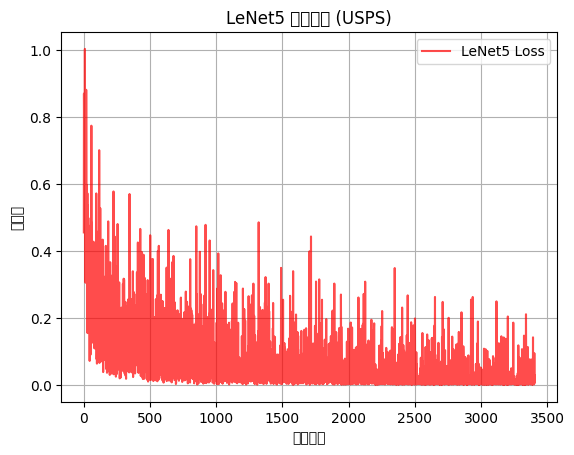


--- 6. 阶段二：VAE 训练 ---
开始 VAE 训练 (使用 TrainOneStepCell)...
加载 LIBSVM 文件: ./data_usps_libsvm/usps.bz2 (用于 train)...
加载完成 'train' 数据。图像 Shape: (7291, 16, 16, 1), 标签 Shape: (7291,)
数据集准备完毕 ('train', LeNet归一化: False)。
使用 'nn.TrainOneStepCell' 进行 VAE 训练。


[WARNING] KERNEL(74746,7f899ba75740,python):2025-04-11-01:01:48.199.022 [mindspore/ccsrc/plugin/device/gpu/kernel/gpu_kernel_factory.cc:93] ReducePrecision] Kernel [StandardNormal] does not support int64, cast input 0 to int32.
[WARNING] PRE_ACT(74746,7f899ba75740,python):2025-04-11-01:01:48.222.825 [mindspore/ccsrc/plugin/device/gpu/optimizer/reduce_precision_fusion.cc:84] Run] Reduce precision for [StandardNormal] input 0


VAE Epoch[1/30] Step[50/113] Loss: 0.5483
VAE Epoch[1/30] Step[100/113] Loss: 0.5004
VAE Epoch 1 结束. 平均 Loss: 0.5208, 耗时: 1.71s
VAE Epoch[2/30] Step[50/113] Loss: 0.4947
VAE Epoch[2/30] Step[100/113] Loss: 0.4960
VAE Epoch 2 结束. 平均 Loss: 0.4955, 耗时: 0.82s
VAE Epoch[3/30] Step[50/113] Loss: 0.4955
VAE Epoch[3/30] Step[100/113] Loss: 0.4911
VAE Epoch 3 结束. 平均 Loss: 0.4936, 耗时: 0.79s
VAE Epoch[4/30] Step[50/113] Loss: 0.4916
VAE Epoch[4/30] Step[100/113] Loss: 0.4947
VAE Epoch 4 结束. 平均 Loss: 0.4928, 耗时: 0.85s
VAE Epoch[5/30] Step[50/113] Loss: 0.4935
VAE Epoch[5/30] Step[100/113] Loss: 0.4928
VAE Epoch 5 结束. 平均 Loss: 0.4931, 耗时: 0.84s
VAE 检查点已保存: ./checkpoints_usps_libsvm_vae/vae_usps_libsvm-e5.ckpt
VAE Epoch[6/30] Step[50/113] Loss: 0.4931
VAE Epoch[6/30] Step[100/113] Loss: 0.4908
VAE Epoch 6 结束. 平均 Loss: 0.4928, 耗时: 0.84s
VAE Epoch[7/30] Step[50/113] Loss: 0.4938
VAE Epoch[7/30] Step[100/113] Loss: 0.4907
VAE Epoch 7 结束. 平均 Loss: 0.4921, 耗时: 0.82s
VAE Epoch[8/30] Step[50/113] Loss: 0.4

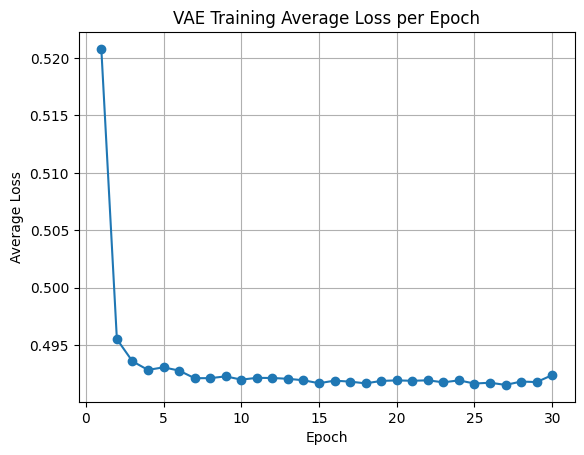


--- 加载 LeNet5 和 VAE 用于遗传算法 ---
成功加载 LeNet5 用于 GA: ./checkpoints_usps_libsvm_lenet_finetuned/lenet_finetuned_usps_libsvm_9-15_227.ckpt
成功加载 VAE 用于 GA: ./checkpoints_usps_libsvm_vae/vae_usps_libsvm-e5.ckpt

--- 7. 阶段三：遗传算法 (VAE 潜在空间) ---

--- 开始遗传算法 (潜在空间): 目标=7, 潜变量维度=20 ---
GA 代 [1/100] - 最高适应度: 0.0646 (耗时: 0.58s)
GA 代 [10/100] - 最高适应度: 0.0675 (耗时: 0.35s)
GA 代 [20/100] - 最高适应度: 0.0681 (耗时: 0.37s)
GA 代 [30/100] - 最高适应度: 0.0683 (耗时: 0.36s)
GA 代 [40/100] - 最高适应度: 0.0688 (耗时: 0.35s)
GA 代 [50/100] - 最高适应度: 0.0689 (耗时: 0.38s)
GA 代 [60/100] - 最高适应度: 0.0692 (耗时: 0.37s)
GA 代 [70/100] - 最高适应度: 0.0695 (耗时: 0.36s)
GA 代 [80/100] - 最高适应度: 0.0695 (耗时: 0.37s)
GA 代 [90/100] - 最高适应度: 0.0701 (耗时: 0.36s)
GA 代 [100/100] - 最高适应度: 0.0706 (耗时: 0.36s)
遗传算法结束。最终最高适应度: 0.0706
遗传算法总耗时: 37.54s


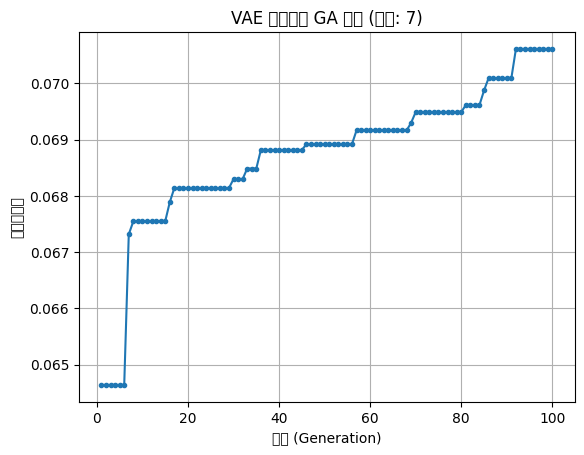


--- 8. 阶段四：评估与可视化 ---

--- 评估 LeNet5 在真实 USPS 测试数据上的性能 ---
执行 LeNet5 在测试集上的最终评估...
===============  开始评估 LeNet5 (LIBSVM)  ===============
加载 LeNet5 检查点: ./checkpoints_usps_libsvm_lenet_finetuned/lenet_finetuned_usps_libsvm_9-15_227.ckpt
加载 LIBSVM 文件: ./data_usps_libsvm/usps.t.bz2 (用于 test)...
加载完成 'test' 数据。图像 Shape: (2007, 16, 16, 1), 标签 Shape: (2007,)
应用 LeNet5 特定的归一化...
数据集准备完毕 ('test', LeNet归一化: True)。
评估数据集批次数: 62
------------------------------
USPS 测试集准确率: {'Accuracy': 0.9627016129032258}
===============  评估结束  ===============

--- 可视化遗传算法生成的最佳图像 ---
解码 GA 找到的最佳潜在向量...
LeNet5 对最佳生成图像的预测: 数字=2, 概率=0.3692


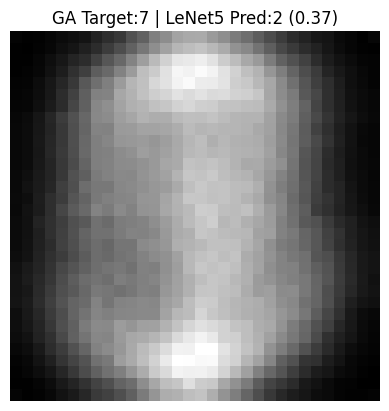


--- 可视化 LeNet5 在真实 USPS 测试数据上的预测 ---
加载 LeNet5 模型进行测试集可视化...
加载 LIBSVM 文件: ./data_usps_libsvm/usps.t.bz2 (用于 test)...
加载完成 'test' 数据。图像 Shape: (2007, 16, 16, 1), 标签 Shape: (2007,)
应用 LeNet5 特定的归一化...
数据集准备完毕 ('test', LeNet归一化: True)。


/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:506: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:506: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:506: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:506: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:506: UserWarning: Glyph 24494 (\N{CJK UNIFIED IDEOGRAPH-5FAE}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:506: UserWarning

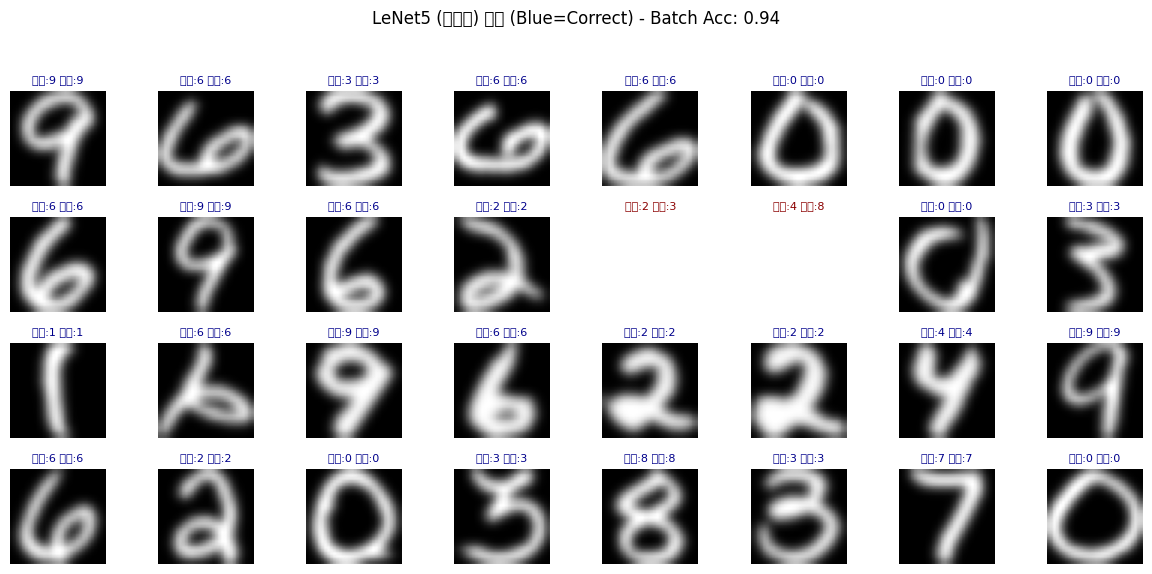


--- 脚本执行完毕 ---


In [22]:
# -*- coding: utf-8 -*-
# === 必要的库导入 ===
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import bz2
import requests # 需要 pip install requests
from urllib.parse import urlparse
from sklearn.datasets import load_svmlight_file # 需要 pip install scikit-learn
import time

# MindSpore 相关库导入
import mindspore
from mindspore import context, Tensor, load_checkpoint, load_param_into_net, save_checkpoint
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore.common import dtype as mstype
import mindspore.nn as nn
import mindspore.ops as ops # 导入 ops
from mindspore.common.initializer import XavierUniform, Normal, TruncatedNormal
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, Callback
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits

# === 1. 配置与环境设置 ===
print("--- 1. 配置环境 ---")
# --- 设备设置 ---
context.set_context(mode=context.GRAPH_MODE, device_target="GPU") # 优先 GPU
# context.set_context(mode=context.GRAPH_MODE, device_target="CPU") # CPU 备选
print(f"MindSpore 版本: {mindspore.__version__}") # 确认版本

# --- 训练控制标志 ---
TRAIN_LENET = True  # True: 训练/微调 LeNet5; False: 尝试加载 LeNet5 检查点
TRAIN_VAE = True    # True: 训练 VAE; False: 尝试加载 VAE 检查点

# --- 路径配置 ---
# !! 重要 !! MNIST 预训练检查点路径 (用于微调起点)
#    如果不想微调，请设置一个无效路径 (如 "" 或 "no_mnist.ckpt")
mnist_checkpoint_path = "./checkpoints/checkpoint_lenet-10_1875.ckpt" # <--- 按需修改为你真实的 MNIST ckpt 路径或置空

# !! 重要 !! USPS 数据集 (LIBSVM bz2 格式) 下载和存放目录
usps_download_dir = "./data_usps_libsvm" # <--- 确保此目录可写

# LeNet5 微调后检查点保存配置
checkpoint_dir_lenet = "./checkpoints_usps_libsvm_lenet_finetuned" # LeNet5 保存目录
checkpoint_prefix_lenet = "lenet_finetuned_usps_libsvm"           # LeNet5 文件前缀
latest_lenet_ckpt_path = ""                                       # 存储找到的最新 LeNet5 检查点

# VAE 训练后检查点保存配置
checkpoint_dir_vae = "./checkpoints_usps_libsvm_vae"       # VAE 保存目录
checkpoint_prefix_vae = "vae_usps_libsvm"                  # VAE 文件前缀
latest_vae_ckpt_path = ""                                  # 存储找到的最新 VAE 检查点

# 数据集 URL
usps_train_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2"
usps_test_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2"

# --- LeNet5 超参数 ---
lenet_finetune_lr = 0.001; lenet_initial_lr = 0.01; lenet_momentum = 0.9
lenet_epochs = 15; lenet_repeat_size = 1; lenet_batch_size = 32

# --- VAE 超参数 ---
vae_lr = 0.001; vae_epochs = 30; vae_latent_dim = 20 # VAE 潜变量维度
vae_beta = 1.0; vae_batch_size = 64; vae_repeat_size = 1

# --- GA (遗传算法) 超参数 ---
ga_population_size = 50; ga_generations = 100
ga_mutation_rate = 0.1; ga_crossover_rate = 0.7; ga_target_digit = 7

# --- 创建必要的目录 ---
os.makedirs(usps_download_dir, exist_ok=True)
os.makedirs(checkpoint_dir_lenet, exist_ok=True)
os.makedirs(checkpoint_dir_vae, exist_ok=True)

# --- 打印配置信息 ---
print(f"MNIST Pre-trained CKPT (微调起点): {os.path.abspath(mnist_checkpoint_path)}")
print(f"USPS LIBSVM Data Dir: {os.path.abspath(usps_download_dir)}")
print(f"LeNet5 Fine-tuned CKPT Dir: {os.path.abspath(checkpoint_dir_lenet)}")
print(f"VAE Trained CKPT Dir: {os.path.abspath(checkpoint_dir_vae)}")

# --- 工具函数：下载文件 ---
def download_file(url, target_dir):
    """如果文件不存在，则从 URL 下载到目标目录。"""
    local_filename = os.path.join(target_dir, os.path.basename(urlparse(url).path))
    if not os.path.exists(local_filename):
        print(f"开始下载: {url} -> {local_filename}")
        try:
            with requests.get(url, stream=True, timeout=60) as r: # 设置超时
                r.raise_for_status(); # 检查请求是否成功
                with open(local_filename, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192): f.write(chunk)
            print("下载完成。")
        except requests.exceptions.RequestException as e: print(f"错误：下载失败: {e}"); raise
    # else: print(f"文件已存在: {local_filename}") # 文件存在时不再打印提示
    return local_filename

# === 2. LeNet5 定义 ===
print("\n--- 2. 定义 LeNet5 网络 ---")
# (LeNet5 定义，带中文注释)
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """定义带 TruncatedNormal 初始化的卷积层"""
    weight_init = TruncatedNormal(0.02); return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, weight_init=weight_init, has_bias=False, pad_mode="valid")
def fc_with_initialize(input_channels, out_channels):
    """定义带 TruncatedNormal 初始化的全连接层"""
    weight_init = TruncatedNormal(0.02); bias_init = TruncatedNormal(0.02); return nn.Dense(input_channels, out_channels, weight_init=weight_init, bias_init=bias_init)
class LeNet5(nn.Cell):
    """经典的 LeNet5 网络结构"""
    def __init__(self, num_class=10): # 输出类别数默认为 10
        super(LeNet5, self).__init__(); self.num_class = num_class; self.conv1 = conv(1, 6, 5); self.relu = nn.ReLU(); self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2); self.conv2 = conv(6, 16, 5); self.flatten = nn.Flatten(); self.fc1 = fc_with_initialize(16*5*5, 120); self.fc2 = fc_with_initialize(120, 84); self.fc3 = fc_with_initialize(84, self.num_class)
    def construct(self, x): # LeNet5 前向传播
        x = self.max_pool2d(self.relu(self.conv1(x))); x = self.max_pool2d(self.relu(self.conv2(x))); x = self.flatten(x); x = self.relu(self.fc1(x)); x = self.relu(self.fc2(x)); x = self.fc3(x); return x

# === 3. VAE 定义 ===
print("\n--- 3. 定义 VAE 网络 ---")
class Encoder(nn.Cell):
    """VAE 编码器：图像 -> 潜在分布参数 (mu, logvar)"""
    def __init__(self, input_channels=1, latent_dim=20):
        super(Encoder, self).__init__(); self.latent_dim = latent_dim; self.conv_layers = nn.SequentialCell(
            nn.Conv2d(input_channels, 32, 4, 2, pad_mode='same', weight_init=XavierUniform()),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, pad_mode='same', weight_init=XavierUniform()),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, pad_mode='same', weight_init=XavierUniform()),
            nn.BatchNorm2d(128), 
            nn.ReLU()
        ); self.flatten = nn.Flatten(); self.dense_layers = nn.SequentialCell(
            nn.Dense(128*4*4, 256, weight_init=XavierUniform()),
            nn.BatchNorm1d(256), 
            nn.ReLU()
        ); self.fc_mu = nn.Dense(256, latent_dim, weight_init=Normal(0.001)); self.fc_logvar = nn.Dense(256, latent_dim, weight_init=Normal(0.001))
    def construct(self, x): x = self.dense_layers(self.flatten(self.conv_layers(x))); return self.fc_mu(x), self.fc_logvar(x)

class Decoder(nn.Cell):
    """VAE 解码器：潜在向量 -> 图像"""
    def __init__(self, latent_dim=20, output_channels=1):
        super(Decoder, self).__init__(); self.latent_dim = latent_dim; self.dense_layers = nn.SequentialCell(
            nn.Dense(latent_dim, 256, weight_init=XavierUniform()),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dense(256, 128*4*4, weight_init=XavierUniform()),
            nn.BatchNorm1d(128*4*4),
            nn.ReLU()
        ); self.reshape = ops.Reshape(); self.target_shape = (-1, 128, 4, 4); self.deconv_layers = nn.SequentialCell(
            nn.Conv2dTranspose(128, 64, 4, 2, pad_mode='same', weight_init=XavierUniform()),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2dTranspose(64, 32, 4, 2, pad_mode='same', weight_init=XavierUniform()),
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.Conv2dTranspose(32, output_channels, 4, 2, pad_mode='same', weight_init=XavierUniform())
        ); self.sigmoid = nn.Sigmoid()
    def construct(self, z): x = self.deconv_layers(self.reshape(self.dense_layers(z), self.target_shape)); return self.sigmoid(x)

class VAE(nn.Cell):
    """完整的 VAE 模型"""
    def __init__(self, input_channels=1, latent_dim=20):
        super(VAE, self).__init__(); self.encoder=Encoder(input_channels,latent_dim); self.decoder=Decoder(latent_dim,input_channels); self.standard_normal=ops.StandardNormal()
    def reparameterize(self, mu, logvar): std=ops.exp(0.5*logvar); epsilon=self.standard_normal(mu.shape); return mu+epsilon*std # 重参数化技巧
    def construct(self, x): mu, logvar=self.encoder(x); z=self.reparameterize(mu,logvar); x_recon=self.decoder(z); return x_recon, mu, logvar # VAE 前向传播
    def decode(self, z): return self.decoder(z) # 单独的解码接口
# VAE 损失函数计算 (修改版，尝试避免 axis=1 问题)
def compute_vae_loss(x_recon, x, mu, logvar, beta=1.0):
    """
    计算 VAE 的总损失 (修改版，尝试兼容 MS 1.7.0 Graph Mode)

    Args:
        x_recon (Tensor): VAE 重建的图像 ([0, 1] 范围)
        x (Tensor): 原始输入图像 ([0, 1] 范围)
        mu (Tensor): 潜在空间均值
        logvar (Tensor): 潜在空间对数方差
        beta (float): KL 散度权重

    Returns:
        Tensor: 总损失, Tensor: 重建损失, Tensor: KL 散度损失
    """
    # --- 重建损失 (BCE) ---
    # 使用 'mean' reduction，让 MindSpore 在内部处理平均
    # 输入 x_recon 和 x 必须是 [0, 1] 范围
    recon_loss_fn = nn.BCELoss(reduction='mean')
    # 直接传入原始图像张量，内部会处理展平和平均
    recon_loss = recon_loss_fn(x_recon, x)
    # print("Recon Loss (mean):", recon_loss) # 调试用

    # --- KL 散度损失 ---
    # KL = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    # 原方法: sum(axis=1) -> mean(axis=0)
    # 新方法: sum over all -> divide by batch_size
    kl_elements = 1 + logvar - ops.square(mu) - ops.exp(logvar)
    # 对所有元素求和 (批次维度和潜变量维度)
    kl_sum_total = ops.reduce_sum(kl_elements) # 返回一个标量 Tensor

    # 获取批次大小 (动态获取在 Graph Mode 下更安全)
    # batch_size = mu.shape[0] # 这种方式在 Graph Mode 可能不支持
    batch_size_tensor = ops.shape(mu)[0] # 使用 ops.shape 获取

    # 计算平均 KL 散度 (需要确保 batch_size > 0)
    # 将 batch_size 转为 float 类型进行除法
    kl_loss = -0.5 * kl_sum_total / ops.cast(batch_size_tensor, mstype.float32)
    # print("KL Loss:", kl_loss) # 调试用

    # --- 总损失 ---
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss
# def compute_vae_loss(x_recon, x, mu, logvar, beta=1.0):
#     """计算 VAE 损失 = 重建损失 + beta * KL散度"""
#     recon_loss_fn = nn.BCELoss(reduction='none'); recon_loss_pp = recon_loss_fn(x_recon.reshape(x.shape[0],-1), x.reshape(x.shape[0],-1)); recon_loss = ops.reduce_mean(ops.reduce_sum(recon_loss_pp, axis=1), axis=0) # BCE 重建损失
#     kl_loss = -0.5 * ops.reduce_mean(ops.reduce_sum(1+logvar-ops.square(mu)-ops.exp(logvar), axis=1), axis=0) # KL 散度
#     return recon_loss + beta * kl_loss, recon_loss, kl_loss # 返回总损失和分项

# === 4. 数据加载函数 (LIBSVM - 支持 VAE 和 LeNet5) ===
print("\n--- 4. 定义数据加载函数 (LIBSVM) ---")
# (数据加载函数定义，带中文注释)
def create_usps_dataset_from_libsvm(data_dir, usage, batch_size=32, repeat_size=1, num_parallel_workers=1, normalize_for_lenet=True):
    """从 LIBSVM bz2 文件加载 USPS 数据集，并根据需要进行归一化处理。"""
    if usage=='train': file_url=usps_train_url
    elif usage=='test': file_url=usps_test_url
    else: raise ValueError("usage 必须是 'train' 或 'test'")
    try: local_file_path = download_file(file_url, data_dir)
    except Exception as e: print(f"数据集文件错误: {e}"); raise

    try:
        print(f"加载 LIBSVM 文件: {local_file_path} (用于 {usage})...")
        X_sparse, y_np = load_svmlight_file(local_file_path, n_features=256)
        X_dense = X_sparse.toarray()
        # 特征值缩放到 [0, 1] - VAE/Sigmoid 输出需要
        if X_dense.min()>=-0.1 and X_dense.max()>1.1: X_scaled = X_dense/2.0
        elif X_dense.min()<-0.1 and X_dense.max()<1.1: X_scaled = (X_dense+1.0)/2.0
        else: X_scaled = X_dense
        X_scaled = np.clip(X_scaled, 0.0, 1.0)
        # 重塑为图像 (N, H, W, C)
        images_np = X_scaled.reshape(X_scaled.shape[0], 16, 16); images_np = np.expand_dims(images_np, axis=-1).astype(np.float32)
        labels_np = y_np.astype(np.int32);
        if np.min(labels_np)==1: labels_np -= 1 # 标签从 0 开始
        print(f"加载完成 '{usage}' 数据。图像 Shape: {images_np.shape}, 标签 Shape: {labels_np.shape}")
        ms_dataset = ds.NumpySlicesDataset({'image': images_np, 'label': labels_np}, column_names=['image', 'label'], shuffle=(usage=='train'))
    except Exception as e: print(f"加载/处理 LIBSVM 出错: {e}"); raise

    # --- 通用预处理 ---
    resize_height, resize_width = 32, 32 # 目标尺寸 32x32
    type_cast_op_label = C.TypeCast(mstype.int32); resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR); hwc2chw_op = CV.HWC2CHW()
    ms_dataset = ms_dataset.map(operations=type_cast_op_label, input_columns="label", num_parallel_workers=num_parallel_workers) # 标签转 int32
    ms_dataset = ms_dataset.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers) # 图像 resize

    # --- 条件化归一化 ---
    if normalize_for_lenet: # 如果是为 LeNet5 准备
        print("应用 LeNet5 特定的归一化..."); rescale_nml = 1.0 / 0.3081; shift_nml = -0.1307 / 0.3081
        rescale_nml_op = CV.Rescale(rescale_nml, shift_nml) # (x/std)-(mean/std)
        ms_dataset = ms_dataset.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    # else: VAE 训练数据保持 [0, 1]

    ms_dataset = ms_dataset.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers) # 转 CHW

    # --- Shuffling, Batching, Repeating ---
    dataset_size = ms_dataset.get_dataset_size(); buffer_size = min(10000, dataset_size if dataset_size > 0 else 1000)
    if usage=='train': ms_dataset = ms_dataset.shuffle(buffer_size=buffer_size) # 打乱训练集
    ms_dataset = ms_dataset.batch(batch_size, drop_remainder=True) # 分批
    if usage=='train': ms_dataset = ms_dataset.repeat(repeat_size) # 重复训练集
    print(f"数据集准备完毕 ('{usage}', LeNet归一化: {normalize_for_lenet})。")
    return ms_dataset

# --- 回调函数定义 (用于记录 LeNet5 Loss) ---
class StepLossInfo(Callback):
    """记录每个 step 的 loss 信息"""
    def __init__(self): super(StepLossInfo, self).__init__(); self.step_loss = {"step": [], "loss_value": []}
    def step_end(self, run_context):
        cb_params = run_context.original_args(); loss = cb_params.net_outputs
        if isinstance(loss, Tensor): loss_val = float(loss.asnumpy())
        else: loss_val = float(loss[0].asnumpy()) # 处理可能的 tuple 输出
        self.step_loss["loss_value"].append(loss_val); self.step_loss["step"].append(cb_params.cur_step_num) # 记录 step 和 loss

# === 5. 阶段一：LeNet5 训练 / 微调 ===
print("\n--- 5. 阶段一：LeNet5 训练/微调 ---")
lenet_network = LeNet5(num_class=10); lenet_load_success = False # 实例化 LeNet5
# 尝试加载 MNIST 预训练权重
if os.path.exists(mnist_checkpoint_path):
    try:
        print(f"尝试加载 MNIST 预训练权重: {mnist_checkpoint_path}"); param_dict_mnist = load_checkpoint(mnist_checkpoint_path); load_param_into_net(lenet_network, param_dict_mnist)
        print("成功加载 MNIST 权重。将进行微调。"); lenet_load_success = True
    except Exception as e: print(f"加载 MNIST 权重失败: {e}。将从头训练。")
else: print(f"警告: 未找到 MNIST 权重 {mnist_checkpoint_path}。将从头训练。")
current_lenet_lr = lenet_finetune_lr if lenet_load_success else lenet_initial_lr # 选择学习率
print(f"LeNet5 训练学习率: {current_lenet_lr}")
lenet_opt = nn.Momentum(lenet_network.trainable_params(), learning_rate=current_lenet_lr, momentum=lenet_momentum) # 优化器
lenet_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean') # 损失函数
lenet_model = Model(lenet_network, lenet_loss, lenet_opt, metrics={"Accuracy": Accuracy()}) # Model API
config_ck_lenet = CheckpointConfig(save_checkpoint_steps=100, keep_checkpoint_max=5); ckpoint_cb_lenet = ModelCheckpoint(prefix=checkpoint_prefix_lenet, config=config_ck_lenet, directory=checkpoint_dir_lenet) # 检查点配置
lenet_loss_info = StepLossInfo() # Loss 回调

# 检查是否跳过 LeNet5 训练
if not TRAIN_LENET:
    try: # 尝试查找最新检查点
        if os.path.exists(checkpoint_dir_lenet): ckpt_files = sorted([f for f in os.listdir(checkpoint_dir_lenet) if f.startswith(checkpoint_prefix_lenet) and f.endswith(".ckpt")]); latest_lenet_ckpt_path = os.path.join(checkpoint_dir_lenet, ckpt_files[-1]) if ckpt_files else ""
        if latest_lenet_ckpt_path: print(f"跳过 LeNet5 训练。找到已有检查点: {latest_lenet_ckpt_path}")
        else: print("跳过 LeNet5 训练，但未找到检查点。")
    except Exception as e: print(f"查找 LeNet 检查点时出错: {e}")

# 执行 LeNet5 训练
if TRAIN_LENET:
    print("开始 LeNet5 训练/微调...")
    ds_lenet_train = create_usps_dataset_from_libsvm(usps_download_dir, 'train', batch_size=lenet_batch_size, repeat_size=lenet_repeat_size, normalize_for_lenet=True) # 加载数据 (带 LeNet 归一化)
    if ds_lenet_train.get_dataset_size() > 0:
        lenet_model.train(lenet_epochs, ds_lenet_train, callbacks=[ckpoint_cb_lenet, LossMonitor(50), lenet_loss_info], dataset_sink_mode=False) # 使用 Model API 训练
        try: # 训练后查找最新检查点
            ckpt_files = sorted([f for f in os.listdir(checkpoint_dir_lenet) if f.startswith(checkpoint_prefix_lenet) and f.endswith(".ckpt")]); latest_lenet_ckpt_path = os.path.join(checkpoint_dir_lenet, ckpt_files[-1]) if ckpt_files else ""
            print(f"LeNet5 训练结束。最新检查点: {latest_lenet_ckpt_path}")
        except Exception as e: print(f"训练后查找 LeNet 检查点出错: {e}")
    else: print("错误：LeNet5 训练数据集为空！")
else: print("按设置跳过 LeNet5 训练。")

# --- LeNet5 训练 Loss 曲线绘制 ---
if TRAIN_LENET and lenet_loss_info.step_loss["step"]: # 只有训练了才绘制
    plt.figure("LeNet5 Training Loss"); plt.plot(lenet_loss_info.step_loss["step"], lenet_loss_info.step_loss["loss_value"], color="red", alpha=0.7, label="LeNet5 Loss")
    plt.xlabel("训练步数"); plt.ylabel("损失值"); plt.title("LeNet5 微调损失 (USPS)"); plt.grid(True); plt.legend(); plt.show()

# === 6. 阶段二：VAE 训练 ===
print("\n--- 6. 阶段二：VAE 训练 ---")
vae_model = VAE(input_channels=1, latent_dim=vae_latent_dim); vae_opt = nn.Adam(vae_model.trainable_params(), learning_rate=vae_lr) # VAE 模型和优化器

# 检查是否跳过 VAE 训练
if not TRAIN_VAE:
    try: # 尝试查找最新 VAE 检查点
        if os.path.exists(checkpoint_dir_vae): ckpt_files = sorted([f for f in os.listdir(checkpoint_dir_vae) if f.startswith(checkpoint_prefix_vae) and f.endswith(".ckpt")]); latest_vae_ckpt_path = os.path.join(checkpoint_dir_vae, ckpt_files[-1]) if ckpt_files else ""
        if latest_vae_ckpt_path: print(f"跳过 VAE 训练。找到检查点: {latest_vae_ckpt_path}")
        else: print("跳过 VAE 训练，但未找到检查点。")
    except Exception as e: print(f"查找 VAE 检查点时出错: {e}")

# -------- VAE 训练部分：使用 TrainOneStepCell --------
if TRAIN_VAE:
    print("开始 VAE 训练 (使用 TrainOneStepCell)...")
    ds_vae_train = create_usps_dataset_from_libsvm(usps_download_dir, 'train', batch_size=vae_batch_size, repeat_size=vae_repeat_size, normalize_for_lenet=False) # 加载 VAE 数据 (不使用 LeNet 归一化)
    vae_train_size = ds_vae_train.get_dataset_size()
    if vae_train_size == 0: print("错误：VAE 训练数据集为空！"); exit()

    # 1. 定义 VAE 损失网络
    class VAEWithLoss(nn.Cell):
        """包装 VAE 网络和损失计算"""
        def __init__(self, network, beta=1.0): super(VAEWithLoss, self).__init__(auto_prefix=False); self._network = network; self.beta = beta
        def construct(self, x): x_recon, mu, logvar = self._network(x); total_loss, _, _ = compute_vae_loss(x_recon, x, mu, logvar, beta=self.beta); return total_loss
    vae_loss_net = VAEWithLoss(vae_model, beta=vae_beta)

    # 2. 实例化 TrainOneStepCell
    vae_train_step_net = nn.TrainOneStepCell(vae_loss_net, vae_opt) # 封装训练步骤
    print("使用 'nn.TrainOneStepCell' 进行 VAE 训练。")

    # 3. VAE 训练循环
    print_freq = 50; total_steps = vae_train_size * vae_epochs; current_step = 0
    vae_train_step_net.set_train() # 设置训练模式
    vae_epoch_losses = [] # 记录每轮平均 loss

    for epoch in range(vae_epochs):
        epoch_start_time = time.time(); step_loss = []
        for i, data in enumerate(ds_vae_train.create_dict_iterator()):
            current_step += 1
            loss = vae_train_step_net(data['image']) # 执行一步训练，获取 loss
            step_loss.append(loss.asnumpy())
            if (i + 1) % print_freq == 0: print(f"VAE Epoch[{epoch+1}/{vae_epochs}] Step[{i+1}/{vae_train_size}] Loss: {np.mean(step_loss[-print_freq:]):.4f}") # 打印进度

        epoch_time = time.time() - epoch_start_time; avg_epoch_loss = np.mean(step_loss) if step_loss else 0.0
        vae_epoch_losses.append(avg_epoch_loss); print(f"VAE Epoch {epoch+1} 结束. 平均 Loss: {avg_epoch_loss:.4f}, 耗时: {epoch_time:.2f}s")
        if (epoch + 1) % 5 == 0 or epoch == vae_epochs - 1: # 定期保存或最终保存 VAE 检查点
            ckpt_path = os.path.join(checkpoint_dir_vae, f"{checkpoint_prefix_vae}-e{epoch+1}.ckpt")
            save_checkpoint(vae_model, ckpt_path); print(f"VAE 检查点已保存: {ckpt_path}"); latest_vae_ckpt_path = ckpt_path

    # 训练结束后再次确认最新 VAE 检查点
    try:
        if os.path.exists(checkpoint_dir_vae): ckpt_files = sorted([f for f in os.listdir(checkpoint_dir_vae) if f.startswith(checkpoint_prefix_vae) and f.endswith(".ckpt")]); latest_vae_ckpt_path = os.path.join(checkpoint_dir_vae, ckpt_files[-1]) if ckpt_files else ""
        print(f"VAE 训练结束。最新检查点: {latest_vae_ckpt_path}")
    except Exception as e: print(f"训练后查找 VAE 检查点出错: {e}")

    # 绘制 VAE 训练 loss 曲线 (按 Epoch)
    if vae_epoch_losses:
        plt.figure("VAE Training Loss"); plt.plot(range(1, len(vae_epoch_losses) + 1), vae_epoch_losses, marker='o', linestyle='-')
        plt.xlabel("Epoch"); plt.ylabel("Average Loss"); plt.title("VAE Training Average Loss per Epoch"); plt.grid(True); plt.show()
else:
    print("按设置跳过 VAE 训练。")
# -------- VAE 训练部分结束 --------


# --- 加载训练好的模型，准备遗传算法 ---
print("\n--- 加载 LeNet5 和 VAE 用于遗传算法 ---")
# 加载 LeNet5 (分类器)
ga_eval_network = LeNet5(num_class=10); CAN_RUN_LENET = False # 用于 GA 适应度评估
if latest_lenet_ckpt_path and os.path.exists(latest_lenet_ckpt_path):
    try: load_param_into_net(ga_eval_network, load_checkpoint(latest_lenet_ckpt_path)); ga_eval_network.set_train(False); print(f"成功加载 LeNet5 用于 GA: {latest_lenet_ckpt_path}"); CAN_RUN_LENET = True
    except Exception as e: print(f"加载 LeNet5 ({latest_lenet_ckpt_path}) 失败: {e}")
else: print("未找到 LeNet5 检查点，无法运行 GA。")
# 加载 VAE (解码器)
loaded_vae = VAE(input_channels=1, latent_dim=vae_latent_dim); CAN_RUN_VAE_DEC = False # 用于 GA 图像生成
if latest_vae_ckpt_path and os.path.exists(latest_vae_ckpt_path):
     try: load_param_into_net(loaded_vae, load_checkpoint(latest_vae_ckpt_path)); loaded_vae.set_train(False); print(f"成功加载 VAE 用于 GA: {latest_vae_ckpt_path}"); CAN_RUN_VAE_DEC = True
     except Exception as e: print(f"加载 VAE ({latest_vae_ckpt_path}) 失败: {e}")
else: print("未找到 VAE 检查点，无法运行 GA。")
CAN_RUN_GA = CAN_RUN_LENET and CAN_RUN_VAE_DEC # 必须两者都成功加载

# === 7. 阶段三：遗传算法 (VAE 潜在空间) ===
print("\n--- 7. 阶段三：遗传算法 (VAE 潜在空间) ---")
# (遗传算法的核心逻辑，带中文注释)
def calculate_fitness(latent_vector_z, target_digit):
     """计算潜在向量 z 的适应度"""
     if not CAN_RUN_GA: return 0.0 # 模型未加载则返回 0
     try:
         z_tensor = Tensor(latent_vector_z.reshape(1, -1), mstype.float32); loaded_vae.set_train(False) # 准备潜向量
         generated_image_0_1 = loaded_vae.decode(z_tensor) # 1. VAE 解码 -> 图像 [0, 1]
         rescale_nml = 1.0 / 0.3081; shift_nml = -0.1307 / 0.3081
         normalized_image = (generated_image_0_1 * rescale_nml) + shift_nml # 2. 应用 LeNet5 归一化
         ga_eval_network.set_train(False); predictions = ga_eval_network(normalized_image) # 3. LeNet5 预测
         probabilities = nn.Softmax()(predictions).asnumpy()[0] # 获取概率
         return float(probabilities[target_digit]) # 4. 返回目标数字概率
     except Exception as e: return 0.0 # 出错返回 0
def initialize_population_latent(ps, ld): return np.random.randn(ps, ld).astype(np.float32) # 初始化潜在向量种群
def crossover_latent_average(p1, p2, cr): # 平均交叉
    if random.random()<cr: a=random.random(); return a*p1+(1-a)*p2, (1-a)*p1+a*p2
    return p1, p2
def mutate_latent_gaussian(ind, mr, ms=0.1): # 高斯变异
    mi=np.copy(ind); mask=np.random.rand(len(ind))<mr; noise=np.random.normal(0,ms,size=ind.shape).astype(ind.dtype); mi[mask]+=noise[mask]; return mi
def selection(pop, fits, ts=3): # 锦标赛选择
    sel=[]; ps=len(pop); [sel.append(pop[random.sample(range(ps),ts)[np.argmax([fits[i] for i in random.sample(range(ps),ts)])]]) for _ in range(ps)]; return sel
def run_genetic_algorithm_latent(pop_size, generations, mutation_rate, crossover_rate, target_digit, latent_dim):
    """执行在 VAE 潜在空间优化的遗传算法"""
    if not CAN_RUN_GA: print("无法运行 GA: 模型未加载。"); return None, []
    print(f"\n--- 开始遗传算法 (潜在空间): 目标={target_digit}, 潜变量维度={latent_dim} ---"); population = initialize_population_latent(pop_size, latent_dim); best_fitness_history = []
    for gen in range(generations): # 迭代 G 代
        start_time_gen = time.time(); fitnesses = [calculate_fitness(ind, target_digit) for ind in population] # 计算适应度
        best_fitness_in_gen = np.max(fitnesses) if fitnesses else 0.0; best_fitness_history.append(best_fitness_in_gen)
        if (gen + 1) % 10 == 0 or gen == 0: print(f"GA 代 [{gen+1}/{generations}] - 最高适应度: {best_fitness_in_gen:.4f} (耗时: {time.time()-start_time_gen:.2f}s)") # 打印进度
        if not fitnesses: print("警告: 适应度计算失败。"); break
        elite = population[np.argmax(fitnesses)]; parents = selection(population, fitnesses); next_population = [elite]; need=pop_size-1; offspring=0; p_idx=0
        while offspring < need: # 生成下一代
             p1=parents[p_idx%pop_size]; p2=parents[(p_idx+1)%pop_size]; p_idx+=2; c1, c2 = crossover_latent_average(p1, p2, crossover_rate); c1 = mutate_latent_gaussian(c1, mutation_rate); c2 = mutate_latent_gaussian(c2, mutation_rate)
             next_population.append(c1); offspring+=1
             if offspring<need: next_population.append(c2); offspring+=1
        population = np.array(next_population).astype(np.float32) # 更新种群
    final_fitnesses = [calculate_fitness(ind, target_digit) for ind in population];
    if not final_fitnesses: return None, best_fitness_history # 处理异常
    best_idx = np.argmax(final_fitnesses); best_latent_vector = population[best_idx]; final_best_fitness = final_fitnesses[best_idx] # 找到最优个体
    print(f"遗传算法结束。最终最高适应度: {final_best_fitness:.4f}")
    return best_latent_vector, best_fitness_history # 返回最优潜向量和适应度历史

# --- 执行遗传算法 ---
best_latent_vec = None; fitness_history = []
if CAN_RUN_GA: # 只有 LeNet5 和 VAE 都加载成功才运行
    ga_start_time = time.time(); best_latent_vec, fitness_history = run_genetic_algorithm_latent(ga_population_size, ga_generations, ga_mutation_rate, ga_crossover_rate, ga_target_digit, vae_latent_dim); print(f"遗传算法总耗时: {time.time() - ga_start_time:.2f}s")
    if fitness_history: # 绘制适应度曲线
        plt.figure("GA Fitness (Latent Space)"); plt.plot(range(1, len(fitness_history) + 1), fitness_history, marker='.')
        plt.xlabel("代数 (Generation)"); plt.ylabel("最高适应度"); plt.title(f"VAE 潜在空间 GA 优化 (目标: {ga_target_digit})"); plt.grid(True); plt.show()
else: print("跳过遗传算法，所需模型未完全加载。")

# === 8. 阶段四：评估与可视化 ===
print("\n--- 8. 阶段四：评估与可视化 ---")
# --- 8a. 在真实测试集上评估 LeNet5 ---
print("\n--- 评估 LeNet5 在真实 USPS 测试数据上的性能 ---")
def test_net_final(eval_network, eval_model, data_download_dir, ckpt_path): # 定义测试函数
    print("="*15, " 开始评估 LeNet5 (LIBSVM) ", "="*15);
    try:
        param_dict = load_checkpoint(ckpt_path); print(f"加载 LeNet5 检查点: {ckpt_path}"); load_param_into_net(eval_network, param_dict)
        ds_eval = create_usps_dataset_from_libsvm(data_download_dir, usage='test', batch_size=32, normalize_for_lenet=True) # 加载测试数据 (带 LeNet 归一化)
        eval_steps = ds_eval.get_dataset_size();
        if eval_steps == 0: print("错误：评估数据集为空。"); return None
        print(f"评估数据集批次数: {eval_steps}"); acc = eval_model.eval(ds_eval, dataset_sink_mode=False) # 执行评估
        print("-" * 30); print(f"USPS 测试集准确率: {acc}"); print("="*15, " 评估结束 ", "="*15); return acc
    except FileNotFoundError: print(f"错误: LeNet5 检查点未找到 {ckpt_path}"); return None
    except Exception as e: print(f"评估 LeNet5 时发生错误: {e}"); return None
if latest_lenet_ckpt_path and os.path.exists(latest_lenet_ckpt_path): # 检查 LeNet5 检查点
    print("执行 LeNet5 在测试集上的最终评估..."); eval_lenet_network = LeNet5(num_class=10); eval_lenet_model = Model(eval_lenet_network, lenet_loss, metrics={"Accuracy": Accuracy()})
    test_net_final(eval_lenet_network, eval_lenet_model, usps_download_dir, latest_lenet_ckpt_path) # 调用测试函数
else: print("跳过 LeNet5 在测试集上的评估：未找到检查点。")

# --- 8b. 可视化 GA 生成的最佳结果 ---
print("\n--- 可视化遗传算法生成的最佳图像 ---")
if best_latent_vec is not None and CAN_RUN_GA: # 检查 GA 是否成功运行并找到最优解
    print("解码 GA 找到的最佳潜在向量...");
    try:
        loaded_vae.set_train(False); ga_eval_network.set_train(False); best_z_tensor = Tensor(best_latent_vec.reshape(1, -1), mstype.float32)
        best_generated_image_tensor = loaded_vae.decode(best_z_tensor); # VAE 解码
        rescale_nml=1.0/0.3081; shift_nml=-0.1307/0.3081; normalized_best_image = (best_generated_image_tensor * rescale_nml) + shift_nml # LeNet5 归一化
        best_img_predictions = ga_eval_network(normalized_best_image); best_img_probs = nn.Softmax()(best_img_predictions).asnumpy()[0] # LeNet5 预测
        best_img_pred_digit = np.argmax(best_img_probs); best_img_pred_prob = best_img_probs[best_img_pred_digit]
        print(f"LeNet5 对最佳生成图像的预测: 数字={best_img_pred_digit}, 概率={best_img_pred_prob:.4f}")
        plt.figure(f"GA Best Image (Latent Space; Target: {ga_target_digit})"); img_to_show = best_generated_image_tensor.asnumpy().squeeze() # 显示 VAE 输出的图像
        plt.imshow(img_to_show, cmap='gray'); plt.title(f"GA Target:{ga_target_digit} | LeNet5 Pred:{best_img_pred_digit} ({best_img_pred_prob:.2f})"); plt.axis('off'); plt.show()
    except Exception as e: print(f"解码或可视化 GA 结果时出错: {e}")
else: print("跳过 GA 结果可视化：未找到最优潜在向量或模型未加载。")

# --- 8c. 可视化 LeNet5 在真实测试集上的预测 ---
print("\n--- 可视化 LeNet5 在真实 USPS 测试数据上的预测 ---")
if latest_lenet_ckpt_path and os.path.exists(latest_lenet_ckpt_path): # 检查 LeNet5 检查点
    try:
        print("加载 LeNet5 模型进行测试集可视化..."); vis_network = LeNet5(num_class=10); vis_model = Model(vis_network)
        load_param_into_net(vis_network, load_checkpoint(latest_lenet_ckpt_path)); vis_network.set_train(False)
        ds_test_vis = create_usps_dataset_from_libsvm(usps_download_dir, 'test', batch_size=32, normalize_for_lenet=True).create_dict_iterator(num_epochs=1, output_numpy=True) # 加载测试数据
        data_vis = next(ds_test_vis); images_vis = data_vis["image"]; labels_vis = data_vis["label"] # 获取一批
        output_probs = vis_model.predict(Tensor(images_vis)); predictions = np.argmax(output_probs.asnumpy(), axis=1) # 预测
        plt.figure("LeNet5 Real Data Predictions (LIBSVM)", figsize=(12, 6)); correct_count = 0 # 准备绘图
        for i in range(len(labels_vis)): # 绘制批次中每个图像的预测结果
            plt.subplot(4, 8, i + 1); color = 'darkblue' if predictions[i] == labels_vis[i] else 'darkred'
            if color == 'darkblue': correct_count +=1; plt.imshow(np.squeeze(images_vis[i]), cmap='gray') # 显示归一化后的图像
            plt.title(f"真实:{labels_vis[i]} 预测:{predictions[i]}", color=color, fontsize=8); plt.xticks([]); plt.yticks([]); plt.axis("off")
        plt.suptitle(f"LeNet5 (微调后) 预测 (Blue=Correct) - Batch Acc: {correct_count/len(labels_vis):.2f}"); plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show() # 显示绘图结果
    except StopIteration: print("无法从测试数据集中获取批次。")
    except FileNotFoundError: print(f"错误: 可视化时找不到检查点 {latest_lenet_ckpt_path}")
    except Exception as e: print(f"测试数据可视化出错: {e}")
else: print("跳过测试数据可视化：未找到 LeNet5 检查点。")

print("\n--- 脚本执行完毕 ---")